In [119]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import math
import matplotlib.pyplot as plt

from mplsoccer import Pitch, VerticalPitch
from matplotlib.colors import to_rgba

In [120]:
df = pd.read_csv(r'C:\Users\Feele\Documents\Data\Sunderland\locationfilter.csv')


In [121]:
#Make a new, single column for time and sort the events in chronological order

df.sort_values(by=['minute'])

#identify the passer and then the recipient, who'll be the playerId of the next action


df['passer'] = df['number'] # change to 'number' for nodes with numbers. Use 'playerId' if not.

df['recipient'] = df['passer'].shift(-1)

#filter for only passes and then successful passes
Passes = df.loc[(df['type/displayName']=="Pass")]


Completions = Passes.loc[(Passes['outcomeType/displayName']=="Successful")]

pas = pd.to_numeric(Completions['passer'],downcast='integer')
rec = pd.to_numeric(Completions['recipient'],downcast='integer')

Completions['passer'] = pas
Completions['recipient'] = rec

C:\Users\Feele\Documents\Analytics\Python\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


In [122]:
#find time of the team's first substitution and filter the df to only passes before that
Subs = df.loc[(df['type/displayName']=="SubstitutionOff")]
SubTimes = Subs["minute"]
SubOne = SubTimes.min()


SubTimes
#SubOne

488    58
490    58
525    62
Name: minute, dtype: int64

In [123]:
Completions = Completions.loc[Completions['minute'] < SubOne]

In [124]:
#Find Average Locations 
average_locs_and_count = Completions.groupby('passer').agg({'x': ['mean'], 'y': ['mean','count']})
average_locs_and_count.columns = ['x', 'y', 'count']

In [125]:
average_locs_and_count

,x,y,count
passer,,,
4,41.374286,56.108571,35
10,68.800000,70.300000,2
11,63.282353,16.664706,17
13,62.994737,45.978947,19
14,62.477778,59.811111,9
15,46.607407,23.107407,27
17,43.785106,87.104255,47
20,13.606667,48.913333,15
25,72.056000,82.908000,25


In [126]:
#find number of passes along each 'path' of passer to recipient
passes_between = Completions.groupby(['passer', 'recipient']).id.count().reset_index()
passes_between.rename({'id': 'pass_count'}, axis='columns', inplace=True)

passes_between = passes_between.merge(average_locs_and_count, left_on='passer', right_index=True)
passes_between = passes_between.merge(average_locs_and_count, left_on='recipient', right_index=True,
                                      suffixes=['', '_end'])

In [136]:
font1 = {'family':'Consolas','color':'black','size':24}

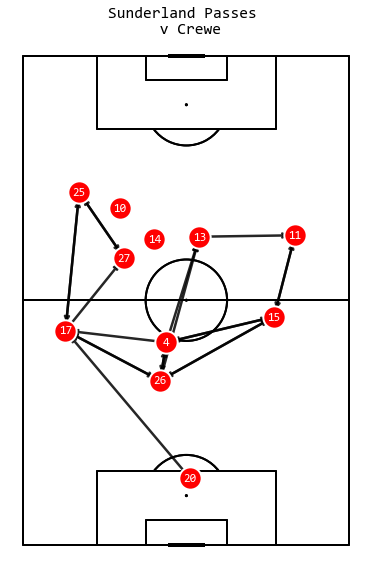

In [135]:
#set minimum threshold for pass arrows to be plotted. So this will only plot combos which occured at least 3 times.

passes_between = passes_between.loc[(passes_between['pass_count']>=5)]

min_transparency = 0.3
color = np.array(to_rgba('#d3d3d3'))
color = np.tile(color, (len(passes_between), 1))
c_transparency = passes_between.pass_count / passes_between.pass_count.max()
c_transparency = (c_transparency * (1 - min_transparency)) + min_transparency
color[:, 3] = c_transparency




pitch = VerticalPitch(pitch_color='white', line_color='black', figsize=(12, 6),
              constrained_layout=True, tight_layout=False,half=False)
fig, ax = pitch.draw(figsize=(13,8))

pitch.draw(ax=ax)

def pass_line_template(ax, x, y, end_x, end_y, line_color):
    ax.annotate('', xy=(80-.8*end_y, 1.2*end_x), xytext=(80-.8*y, 1.2*x), zorder=.5,
    arrowprops=dict(arrowstyle='->', linewidth=2.5, color='black', alpha=.85))
    
def pass_line_template_shrink(ax, x, y, end_x, end_y, line_color, dist_delta=1.2):
    dist = math.hypot(end_x - x, end_y - y)
    angle = math.atan2(end_y-y, end_x-x)
    upd_x = x + (dist - dist_delta) * math.cos(angle)
    upd_y = y + (dist - dist_delta) * math.sin(angle)
    pass_line_template(ax, x, y, upd_x, upd_y, line_color="red")

#plt.axhspan(39.75, 40,color='#B4B6BA', alpha=1)
#plt.axhspan(0, 39.75,color='red', alpha=.25)
#plt.xlim(-2,82)
#plt.axhspan(79.75, 80,color='#B4B6BA', alpha=1)
#plt.axhspan(80, 120 ,color='green', alpha=.25)

#Plotting Circles

pass_nodes = pitch.scatter(1.2*average_locs_and_count.x, 80-0.8*average_locs_and_count.y, s=500,
                           color='red', edgecolors="white", linewidth=2, alpha=1, ax=ax, zorder=2) #CHANGE COLOURS HERE
 


#Plotting Lines

for index, row in passes_between.iterrows():
    pass_line_template_shrink(ax,row['x'],row['y'],row['x_end'],row['y_end'],line_color = 'white')
                    
# Plotting Numbers
for index, row in average_locs_and_count.iterrows():
     pitch.annotate(row.name, xy=(1.2*row.x, 80-0.8*row.y), c='white', va='center', ha='center', size=12, fontfamily="Consolas",ax=ax)


        
plt.title("Sunderland Passes \n v Crewe",fontdict= font1) # Title


plt.savefig('networks.png',dpi=500,bbox_inches = 'tight')        